In [183]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# DataFrame

let us create a DataFrame. We can use this DataFrame to do value_counts and other EDA.

In [185]:
data = []
labels = []
data_dir = '/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry'
image_size = (224, 224)

subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir, subfolder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        data.append(os.path.join(subfolder, image_file))
        labels.append(label)

        
# Create a DataFrame from the data and labels
df = pd.DataFrame({'image_file': data, 'label': labels})
df.head()

,image_file,label
0,jerry/frame5391.jpg,0
1,jerry/frame5112.jpg,0
2,jerry/frame1976.jpg,0
3,jerry/frame4667.jpg,0
4,jerry/frame4283.jpg,0


## Let's create a simple function that will randomly give us an image path
 I will be using this function later to plot the feature maps of a random image

In [246]:
import random
from keras.preprocessing.image import load_img

def get_random_img_path():
    random_path = random.choice(df.image_file.values)
    return os.path.join(data_dir, random_path)

get_random_img_path()

'/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry/tom_jerry_0/frame59.jpg'

# VGG16 Model


In [187]:
from torch import nn
import torchvision.models as models

vgg16_model = models.vgg16()

### Let's take a look at all the layers that are available here

In [226]:
all_layers = list(vgg16_model.children())[0]
for idx, layer in enumerate(all_layers):
    print(f"index: {idx:02d} | layer: {layer}")

index: 00 | layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 01 | layer: ReLU(inplace=True)
index: 02 | layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 03 | layer: ReLU(inplace=True)
index: 04 | layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
index: 05 | layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 06 | layer: ReLU(inplace=True)
index: 07 | layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 08 | layer: ReLU(inplace=True)
index: 09 | layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
index: 10 | layer: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 11 | layer: ReLU(inplace=True)
index: 12 | layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 13 | layer: ReLU(inplace=True)
index: 14 | layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

### Here's a simple function that will extract the convolution filters and plot them for a layer

In [232]:
import matplotlib.pyplot as plt

def plot_filters(all_layers, layer_idx):
    filters = all_layers[layer_idx].weight.data.cpu().numpy()

    # Normalize filter values to 0-1
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # Plot first few filters
    n_filters = 6
    ix = 1
    for i in range(n_filters):
        f = filters[i]
        for j in range(3):
            plt.subplot(n_filters, 3, ix)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(f[j], cmap='gray')
            ix += 1
    plt.show()

# I need to call the above function and pass only those indexes that have a convolution layer. So let's see what indexes have a convolution layer

In [189]:
for idx, layer in enumerate(all_layers):
    if "Conv" in layer.__class__.__name__:
        print(f"index: {idx:02d} | layer: {layer}")

index: 00 | layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 02 | layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 05 | layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 07 | layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 10 | layer: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 12 | layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 14 | layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 17 | layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 19 | layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 21 | layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 24 | layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
index: 26 | layer: Conv2d(512, 512, kernel_size=(

# Let's see how these filters look like

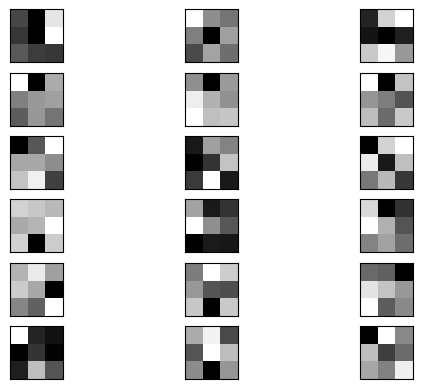

In [235]:
layer_idx = 28
plot_filters(all_layers, layer_idx)

# Plot feature maps

### Now let's read a random image and plot it's feature map

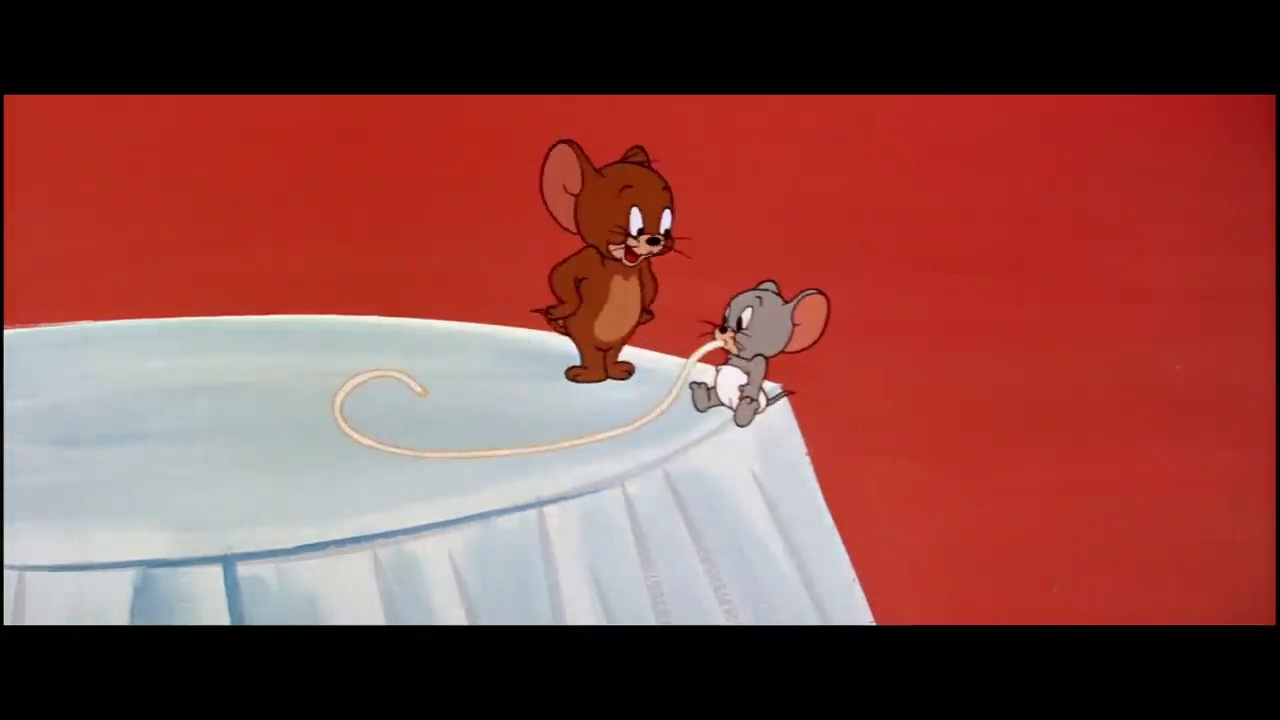

In [271]:
random_path = get_random_img_path()
img = load_img(random_path)
img

## Modify the `layer_idx` vairable in below cell to truncate the layers

In [275]:
layer_idx = 3
partial_model = all_layers[:layer_idx]
partial_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [278]:
import torchvision
import torch
from torchvision import datasets, transforms

transformation_steps = transforms.Compose([
    transforms.Resize((64, 64)), # Do not change
    transforms.ToTensor()
])

trans_img = transformation_steps(img)

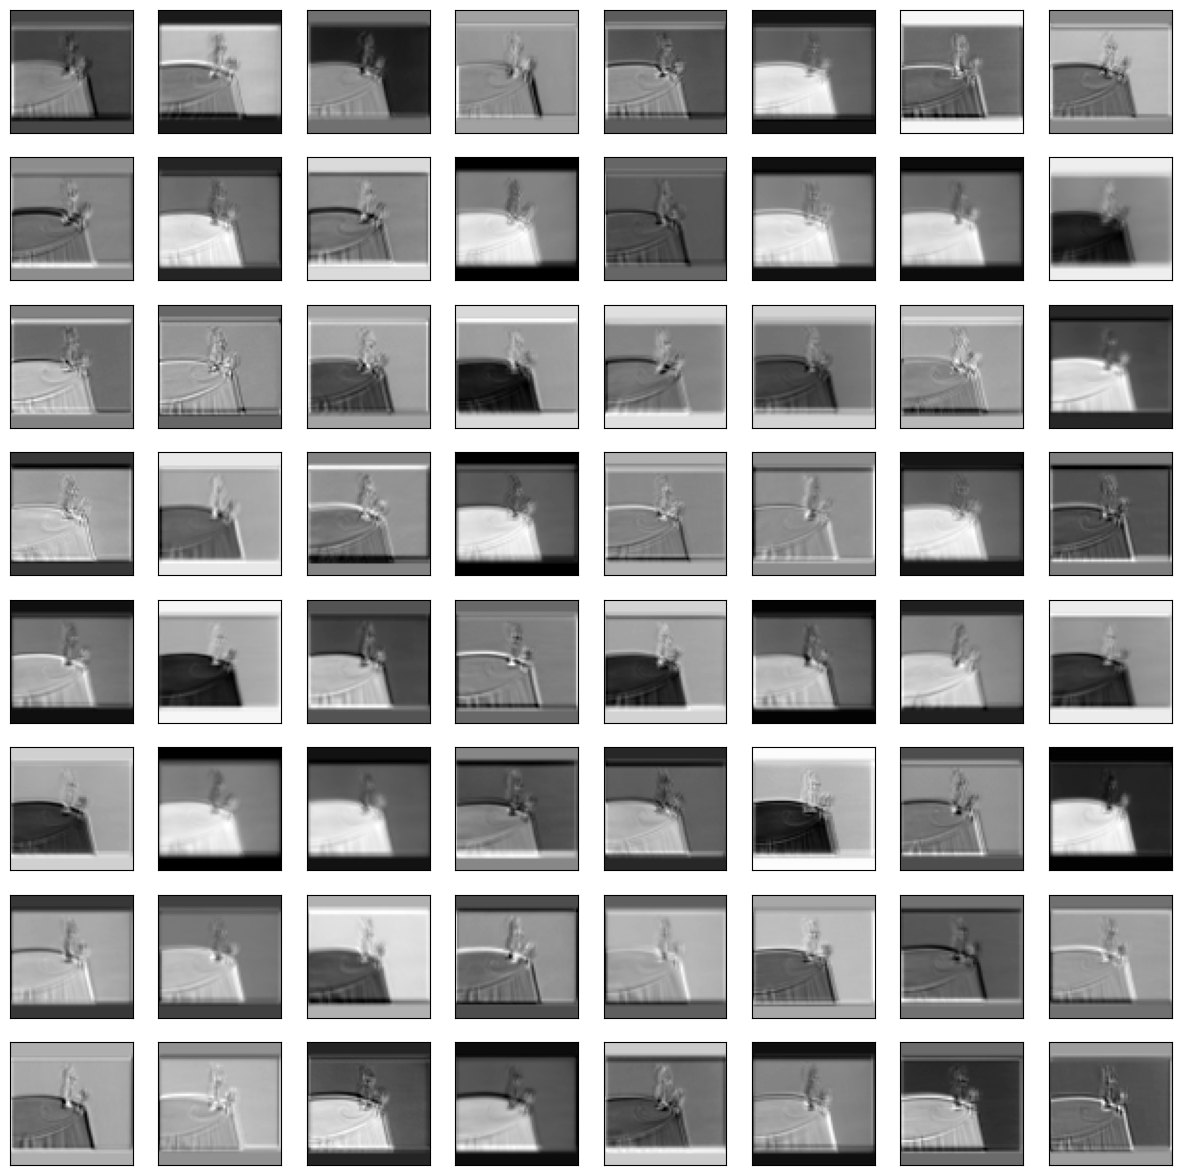

In [279]:
from matplotlib import pyplot

pyplot.figure(figsize=(15, 15))

with torch.inference_mode():
    feature_maps = partial_model(trans_img)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()